This script:

1. Loads both datasets
2. Withholds the 3 specified cruises from bottle data (~6%)
3. Finds date ranges and withholds corresponding CTD data (~3%)
4. Does stratified random sampling to bring both up to 10% evaluation
5. Saves 4 files: bottle_training, bottle_evaluation, CTD_training, CTD_evaluation

The stratification is by CRUISE_ID for bottle data and by year for CTD data.

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import glob

## Load Data

In [3]:
# Load bottle data
df_bottle = pd.read_csv('/home/sbeairsto/projects/line_p/data/chemical/LineP_for_Data_Synthesis_1990-2019_v1.csv')

# Load CTD data
ctd_files = glob.glob('/home/sbeairsto/projects/line_p/data/physical/LineP_ctds_*_binned_1m.csv')
ctd_dfs = []
for file in ctd_files:
    df_ctd = pd.read_csv(file, parse_dates=['time'])
    ctd_dfs.append(df_ctd)
ctd_df = pd.concat(ctd_dfs, ignore_index=True)

print(f"Original bottle data: {len(df_bottle)} rows")
print(f"Original CTD data: {len(ctd_df)} rows")

Original bottle data: 4983 rows
Original CTD data: 6961569 rows


## 2. Withhold specific cruises (Bottle data)

In [8]:
eval_cruises = [2006.15, 2010.13, 2018.01]

# Separate evaluation cruises from bottle data
bottle_eval_cruises = df_bottle[df_bottle['CRUISE_ID'].isin(eval_cruises)].copy()
bottle_remaining = df_bottle[~df_bottle['CRUISE_ID'].isin(eval_cruises)].copy()

print(f"\nBottle eval cruises: {len(bottle_eval_cruises)} rows ({len(bottle_eval_cruises)/len(df_bottle)*100:.1f}%)")
print(f"Bottle remaining: {len(bottle_remaining)} rows")


Bottle eval cruises: 323 rows (6.5%)
Bottle remaining: 4660 rows


## 3. Find date ranges for eval cruises

In [64]:
# Create date column for bottle data
bottle_eval_cruises['DATE_UTC'] = pd.to_datetime(
    bottle_eval_cruises['YEAR_UTC'].astype(str) + '-' + 
    bottle_eval_cruises['MONTH_UTC'].astype(str).str.zfill(2) + '-' + 
    bottle_eval_cruises['DAY_UTC'].astype(str).str.zfill(2)
)

# Get date ranges for each eval cruise
date_ranges = []
for cruise in eval_cruises:
    cruise_data = bottle_eval_cruises[bottle_eval_cruises['CRUISE_ID'] == cruise]
    start_date = cruise_data['DATE_UTC'].min() - timedelta(days=2)
    end_date = cruise_data['DATE_UTC'].max() + timedelta(days=2)
    date_ranges.append((start_date, end_date))
    print(f"Cruise {cruise}: {start_date.date()} to {end_date.date()}")

Cruise 2006.15: 2006-09-21 to 2006-09-30
Cruise 2010.13: 2010-06-05 to 2010-06-15
Cruise 2018.01: 2018-02-19 to 2018-03-06


## 4. Withhold CTD data based on date ranges

In [65]:
# Convert CTD time to datetime if needed
ctd_df['time'] = pd.to_datetime(ctd_df['time'])

# Filter CTD data for eval cruises based on date ranges
ctd_eval_mask = pd.Series(False, index=ctd_df.index)
for start_date, end_date in date_ranges:
    mask = (ctd_df['time'] >= start_date) & (ctd_df['time'] <= end_date)
    ctd_eval_mask = ctd_eval_mask | mask

ctd_eval_cruises = ctd_df[ctd_eval_mask].copy()
ctd_remaining = ctd_df[~ctd_eval_mask].copy()

print(f"\nCTD eval cruises: {len(ctd_eval_cruises)} rows ({len(ctd_eval_cruises)/len(ctd_df)*100:.1f}%)")
print(f"CTD remaining: {len(ctd_remaining)} rows")


CTD eval cruises: 198298 rows (2.8%)
CTD remaining: 6763271 rows


## 5. Additional stratified random sampling to reach 10%

In [66]:
def balanced_stratified_sample(df, strata_cols, n_samples, random_state=42):
    """
    Sample with inverse weighting to balance across strata
    """
    df = df.copy()
    np.random.seed(random_state)
    
    # Create combined strata
    df['strata'] = df[strata_cols[0]].astype(str)
    for col in strata_cols[1:]:
        df['strata'] = df['strata'] + '_' + df[col].astype(str)
    
    # Weight inversely to stratum size
    strata_sizes = df['strata'].value_counts()
    df['weight'] = df['strata'].map(lambda x: 1.0 / strata_sizes[x])
    df['weight'] = df['weight'] / df['weight'].sum()
    
    # Sample
    sampled_indices = np.random.choice(
        df.index, 
        size=min(n_samples, len(df)),
        replace=False,
        p=df['weight'].values
    )
    
    return df.loc[sampled_indices].drop(columns=['strata', 'weight'])

# Calculate additional samples needed for 10%
bottle_target_eval = int(len(df_bottle) * 0.10)
bottle_additional_needed = bottle_target_eval - len(bottle_eval_cruises)

ctd_target_eval = int(len(ctd_df) * 0.10)
ctd_additional_needed = ctd_target_eval - len(ctd_eval_cruises)

print(f"\nBottle: sampling {bottle_additional_needed} more for 10% eval")
bottle_random_eval = balanced_stratified_sample(
    bottle_remaining, 
    ['YEAR_UTC', 'MONTH_UTC', 'STATION_ID'],
    bottle_additional_needed
)

print(f"\nCTD: sampling {ctd_additional_needed} more for 10% eval")
ctd_remaining['year'] = ctd_remaining['time'].dt.year
ctd_remaining['month'] = ctd_remaining['time'].dt.month
ctd_random_eval = balanced_stratified_sample(
    ctd_remaining,
    ['year', 'month', 'closest_linep_station_name'],
    ctd_additional_needed
)

# Combine for final sets
bottle_evaluation = pd.concat([bottle_eval_cruises, bottle_random_eval], ignore_index=True)
bottle_training = bottle_remaining[~bottle_remaining.index.isin(bottle_random_eval.index)].copy()

ctd_evaluation = pd.concat([ctd_eval_cruises, ctd_random_eval], ignore_index=True)
ctd_training = ctd_remaining[~ctd_remaining.index.isin(ctd_random_eval.index)].copy()

# Clean up temporary columns
ctd_training = ctd_training.drop(columns=['year', 'month'], errors='ignore')
ctd_evaluation = ctd_evaluation.drop(columns=['year', 'month'], errors='ignore')
bottle_training = bottle_training.drop(columns=['DATE_UTC'], errors='ignore')
bottle_evaluation = bottle_evaluation.drop(columns=['DATE_UTC'], errors='ignore')


Bottle: sampling 175 more for 10% eval

CTD: sampling 497858 more for 10% eval


## 6. Verify split percentages

In [67]:
print(f"\n=== FINAL RESULTS ===")
print(f"Bottle training: {len(bottle_training)} rows ({len(bottle_training)/len(df_bottle)*100:.1f}%)")
print(f"Bottle evaluation: {len(bottle_evaluation)} rows ({len(bottle_evaluation)/len(df_bottle)*100:.1f}%)")
print(f"Total bottle: {len(bottle_training) + len(bottle_evaluation)} (should be {len(df_bottle)})")

print(f"\nCTD training: {len(ctd_training)} rows ({len(ctd_training)/len(ctd_df)*100:.1f}%)")
print(f"CTD evaluation: {len(ctd_evaluation)} rows ({len(ctd_evaluation)/len(ctd_df)*100:.1f}%)")
print(f"Total CTD: {len(ctd_training) + len(ctd_evaluation)} (should be {len(ctd_df)})")


=== FINAL RESULTS ===
Bottle training: 4485 rows (90.0%)
Bottle evaluation: 498 rows (10.0%)
Total bottle: 4983 (should be 4983)

CTD training: 6265413 rows (90.0%)
CTD evaluation: 696156 rows (10.0%)
Total CTD: 6961569 (should be 6961569)


## 7. Save files

In [69]:
output_dir = '/home/sbeairsto/projects/line_p/data/observation/'

bottle_training.to_csv(f'{output_dir}bottle_training.csv', index=False)
bottle_evaluation.to_csv(f'{output_dir}bottle_evaluation.csv', index=False)
ctd_training.to_csv(f'{output_dir}CTD_training.csv', index=False)
ctd_evaluation.to_csv(f'{output_dir}CTD_evaluation.csv', index=False)

print(f"\nFiles saved to {output_dir}")


Files saved to /home/sbeairsto/projects/line_p/data/observation/



STRATIFICATION CHECK: BOTTLE DATA

Total strata: 212
Mean eval proportion: 0.103
Std eval proportion: 0.242
Min eval proportion: 0.000
Max eval proportion: 1.000

Top 5 strata furthest from 10% eval:
dataset    training  evaluation  total  eval_prop
strata                                           
2006_9_12         0          23     23        1.0
2006_9_16         0          24     24        1.0
2006_9_20         0          24     24        1.0
2006_9_26         0          24     24        1.0
2010_6_12         0          23     23        1.0

--- Breakdown by YEAR_UTC ---
dataset   training  evaluation  total  eval_prop
YEAR_UTC                                        
1990           250           8    258   0.031008
1991            26           2     28   0.071429
1992           267          10    277   0.036101
1993           109           6    115   0.052174
1994           164           5    169   0.029586
1995            63           1     64   0.015625
1996           243        

/tmp/ipykernel_1216302/1404713411.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2,0].set_xticklabels(['Feb', 'Mar', 'May', 'Jun',



Plot saved to: /home/sbeairsto/projects/line_p/data/observation/stratification_check.png


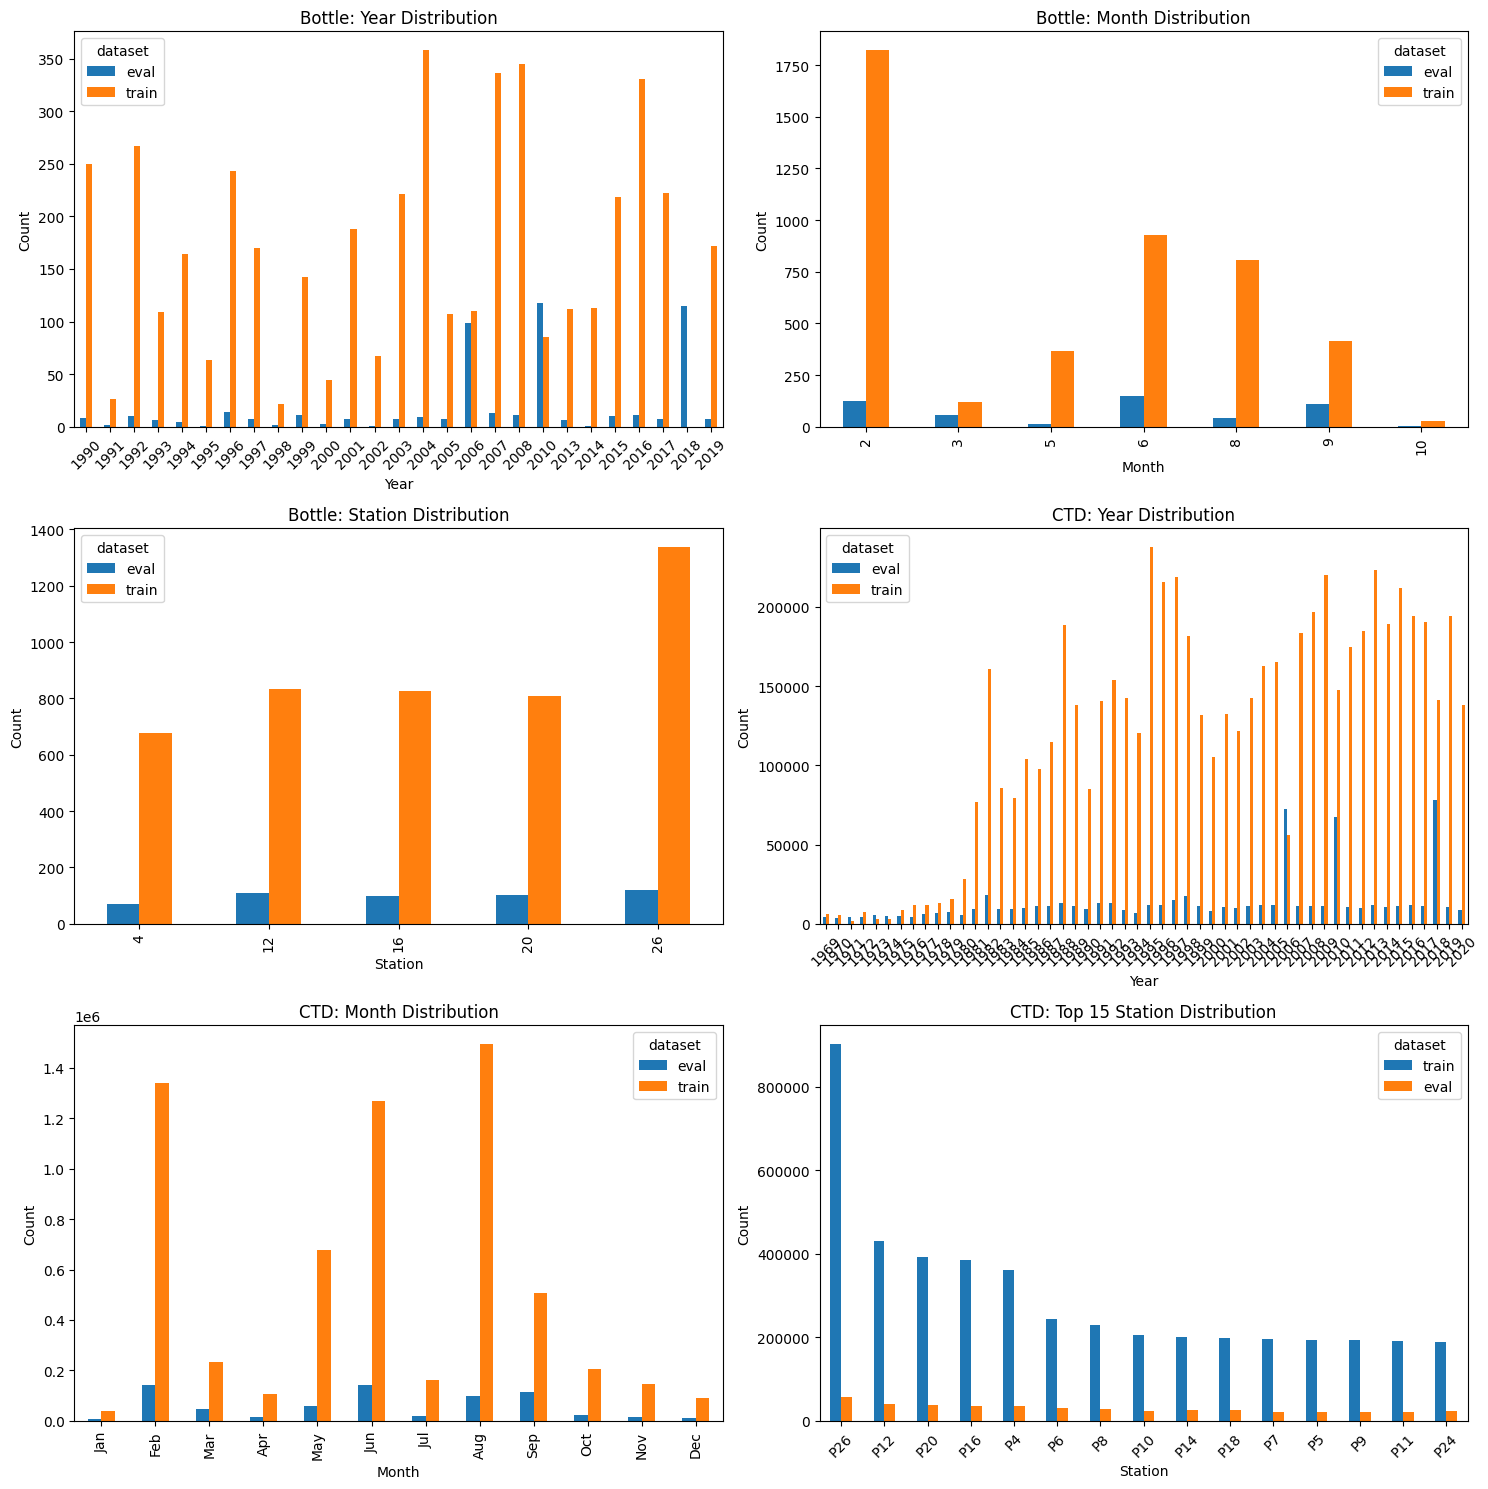

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# VERIFY STRATIFICATION
# ============================================================================

def check_stratification(training, evaluation, strata_cols, dataset_name):
    """
    Check if evaluation set has similar proportions to training set across strata
    """
    print(f"\n{'='*60}")
    print(f"STRATIFICATION CHECK: {dataset_name}")
    print(f"{'='*60}")
    
    # Combine datasets with labels
    training_copy = training.copy()
    evaluation_copy = evaluation.copy()
    training_copy['dataset'] = 'training'
    evaluation_copy['dataset'] = 'evaluation'
    combined = pd.concat([training_copy, evaluation_copy])
    
    # Create strata column
    combined['strata'] = combined[strata_cols[0]].astype(str)
    for col in strata_cols[1:]:
        combined['strata'] = combined['strata'] + '_' + combined[col].astype(str)
    
    # Calculate proportions
    strata_counts = combined.groupby(['strata', 'dataset']).size().unstack(fill_value=0)
    strata_counts['total'] = strata_counts.sum(axis=1)
    strata_counts['train_prop'] = strata_counts['training'] / strata_counts['total']
    strata_counts['eval_prop'] = strata_counts['evaluation'] / strata_counts['total']
    strata_counts['difference'] = abs(strata_counts['eval_prop'] - 0.10)
    
    print(f"\nTotal strata: {len(strata_counts)}")
    print(f"Mean eval proportion: {strata_counts['eval_prop'].mean():.3f}")
    print(f"Std eval proportion: {strata_counts['eval_prop'].std():.3f}")
    print(f"Min eval proportion: {strata_counts['eval_prop'].min():.3f}")
    print(f"Max eval proportion: {strata_counts['eval_prop'].max():.3f}")
    
    # Show strata with largest deviations from 10%
    print(f"\nTop 5 strata furthest from 10% eval:")
    print(strata_counts.nlargest(5, 'difference')[['training', 'evaluation', 'total', 'eval_prop']])
    
    # Summary by individual stratification variables
    for col in strata_cols:
        print(f"\n--- Breakdown by {col} ---")
        col_summary = combined.groupby([col, 'dataset']).size().unstack(fill_value=0)
        col_summary['total'] = col_summary.sum(axis=1)
        col_summary['eval_prop'] = col_summary['evaluation'] / col_summary['total']
        print(col_summary[['training', 'evaluation', 'total', 'eval_prop']])
    
    return strata_counts

# For BOTTLE data
bottle_training = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/bottle_training.csv')
bottle_evaluation = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/bottle_evaluation.csv')

bottle_strata = check_stratification(
    bottle_training, 
    bottle_evaluation, 
    ['YEAR_UTC', 'MONTH_UTC', 'STATION_ID'],
    'BOTTLE DATA'
)

# For CTD data - use format='ISO8601' to handle microseconds
ctd_training = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/CTD_training.csv')
ctd_evaluation = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/CTD_evaluation.csv')

# Convert time column properly
ctd_training['time'] = pd.to_datetime(ctd_training['time'], format='ISO8601')
ctd_evaluation['time'] = pd.to_datetime(ctd_evaluation['time'], format='ISO8601')

# Add year and month for CTD
ctd_training['year'] = ctd_training['time'].dt.year
ctd_training['month'] = ctd_training['time'].dt.month
ctd_evaluation['year'] = ctd_evaluation['time'].dt.year
ctd_evaluation['month'] = ctd_evaluation['time'].dt.month

ctd_strata = check_stratification(
    ctd_training, 
    ctd_evaluation, 
    ['year', 'month', 'closest_linep_station_name'],
    'CTD DATA'
)

# ============================================================================
# VISUALIZE STRATIFICATION
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Bottle: Year distribution
bottle_year = pd.concat([bottle_training.assign(dataset='train'), 
                         bottle_evaluation.assign(dataset='eval')])
bottle_year_counts = bottle_year.groupby(['YEAR_UTC', 'dataset']).size().unstack(fill_value=0)
bottle_year_counts.plot(kind='bar', ax=axes[0,0], title='Bottle: Year Distribution')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Bottle: Month distribution
bottle_month_counts = bottle_year.groupby(['MONTH_UTC', 'dataset']).size().unstack(fill_value=0)
bottle_month_counts.plot(kind='bar', ax=axes[0,1], title='Bottle: Month Distribution')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Count')
axes[2,0].set_xticklabels(['Feb', 'Mar', 'May', 'Jun', 
                            'Aug', 'Sep', 'Oct'][:len(ctd_month_counts)])

# Bottle: Station distribution
bottle_station_counts = bottle_year.groupby(['STATION_ID', 'dataset']).size().unstack(fill_value=0)
bottle_station_counts.plot(kind='bar', ax=axes[1,0], title='Bottle: Station Distribution')
axes[1,0].set_xlabel('Station')
axes[1,0].set_ylabel('Count')

# CTD: Year distribution
ctd_year = pd.concat([ctd_training.assign(dataset='train'), 
                      ctd_evaluation.assign(dataset='eval')])
ctd_year_counts = ctd_year.groupby(['year', 'dataset']).size().unstack(fill_value=0)
ctd_year_counts.plot(kind='bar', ax=axes[1,1], title='CTD: Year Distribution')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)

# CTD: Month distribution
ctd_month_counts = ctd_year.groupby(['month', 'dataset']).size().unstack(fill_value=0)
ctd_month_counts.plot(kind='bar', ax=axes[2,0], title='CTD: Month Distribution')
axes[2,0].set_xlabel('Month')
axes[2,0].set_ylabel('Count')
axes[2,0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(ctd_month_counts)])

# CTD: Station distribution (top 15 stations)
ctd_station_counts = ctd_year.groupby(['closest_linep_station_name', 'dataset']).size().unstack(fill_value=0)
ctd_station_counts['total'] = ctd_station_counts.sum(axis=1)
ctd_station_counts.nlargest(15, 'total')[['train', 'eval']].plot(kind='bar', ax=axes[2,1], 
                                                                   title='CTD: Top 15 Station Distribution')
axes[2,1].set_xlabel('Station')
axes[2,1].set_ylabel('Count')
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/home/sbeairsto/projects/line_p/data/observation/stratification_check.png', dpi=150, bbox_inches='tight')
print("\nPlot saved to: /home/sbeairsto/projects/line_p/data/observation/stratification_check.png")